In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from geotiff_processor import GeotiffProcessor
from ice_modeler import IceModeler

Using TensorFlow backend.


In [3]:
geotiff_index = pd.read_csv('daily_northern_geotiff_index.csv')
geotiff_index.date = pd.to_datetime(geotiff_index.date)
geotiff_index = geotiff_index.set_index('date')

In [4]:
geotiff_concentration = geotiff_index.loc[geotiff_index.image_type == 'concentration']

In [5]:
conc_last_ten = geotiff_concentration.loc['2009-01-01':'2018-12-31',:]

In [6]:
conc_processor = GeotiffProcessor('raw_images/', image_index=conc_last_ten)

In [7]:
conc_last_ten

,Unnamed: 0,file_name,hemisphere,image_type
date,,,,
2009-01-01,N_20090101_concentration_v3.0,daily/geotiff/2009/N_20090101_concentration_v3...,north,concentration
2009-01-02,N_20090102_concentration_v3.0,daily/geotiff/2009/N_20090102_concentration_v3...,north,concentration
2009-01-03,N_20090103_concentration_v3.0,daily/geotiff/2009/N_20090103_concentration_v3...,north,concentration
2009-01-04,N_20090104_concentration_v3.0,daily/geotiff/2009/N_20090104_concentration_v3...,north,concentration
2009-01-05,N_20090105_concentration_v3.0,daily/geotiff/2009/N_20090105_concentration_v3...,north,concentration
...,...,...,...,...
2018-12-27,N_20181227_concentration_v3.0,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,N_20181228_concentration_v3.0,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,N_20181229_concentration_v3.0,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration


In [8]:
conc_processor.load_default_colormaps(
    extent='default_extent_colormap.pkl',
    concentration='default_concentration_colormap.pkl')
# conc_last_ten = conc_processor.impute_missing_index_dates(set_this_index=True)

In [9]:
ice_modeler = IceModeler()

In [10]:
conc_images, years = conc_processor.process_images_channels_first_yearly_sample()

In [11]:
norm_images = ice_modeler.scale_to_normal(conc_images, image_type='concentration')

In [12]:
conc_images_flat = ice_modeler.reshape_to_tcn(norm_images)

In [13]:
conc_images_flat.shape

(10, 365, 136192)

In [14]:
x_train = conc_images_flat[:7]
y_train = conc_images_flat[1:8]
x_test = conc_images_flat[7:10]
y_test = conc_images_flat[8:]

In [15]:
scaled_tanh = ice_modeler.make_hard_tanh(1)

In [16]:
ice_modeler.reset_model()
ice_modeler.add_n_tcn(1, nb_filters=1200, kernel_size=7, nb_stacks=10)
ice_modeler.add_n_tcn(1, nb_filters=1000, kernel_size=14, nb_stacks=10)
#ice_modeler.add_n_tcn(1, nb_filters=5, kernel_size=14, nb_stacks=4)
#ice_modeler.add_n_tcn(1, nb_filters=5, kernel_size=30, nb_stacks=4)
ice_modeler.add_n_dense(1, ice_modeler.image_size)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
mean_squared_error = ice_modeler.make_power_error(2)
ice_modeler.compile(loss=mean_squared_error, optimizer='adam')

In [ ]:
ice_modeler.fit(x_train, y_train, epochs=5)

Epoch 1/5
1/7 [===>..........................] - ETA: 41:19 - loss: 1.3935

In [184]:
predictions = ice_modeler.predict(x_train)

In [185]:
predictions.shape

(7, 365, 136192)

In [186]:
predictions_images_unscaled = ice_modeler.reshape_to_image(predictions)

In [187]:
predictions_images = ice_modeler.scale_from_normal(predictions_images_unscaled, image_type='concentration')

[[   57 65519 65347 ...  2540  2540  2540]
 [65422   119    22 ...  2540  2540  2540]
 [  146    99   151 ...  2540  2540  2540]
 ...
 [ 2540  2540  2540 ...   131   128   224]
 [ 2540  2540  2540 ... 65400 65324 65501]
 [ 2540  2540  2540 ... 65514    67    72]]
[[  57.036278  -17.413239 -189.12816  ... 2540.       2540.
  2540.      ]
 [-114.61438   119.95086    22.5692   ... 2540.       2540.
  2540.      ]
 [ 146.70993    99.850174  151.95238  ... 2540.       2540.
  2540.      ]
 ...
 [2540.       2540.       2540.       ...  131.90106   128.1297
   224.17596 ]
 [2540.       2540.       2540.       ... -136.13147  -212.3116
   -35.400448]
 [2540.       2540.       2540.       ...  -22.001247   67.34919
    72.265915]]
[[65505 65473 65325 ...  2540  2540  2540]
 [65432   147 65482 ...  2540  2540  2540]
 [    9   141   144 ...  2540  2540  2540]
 ...
 [ 2540  2540  2540 ...    88   165   267]
 [ 2540  2540  2540 ... 65379 65323    13]
 [ 2540  2540  2540 ... 65423    73    62]]
[[ 

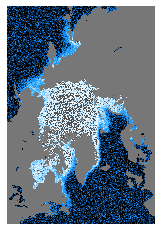

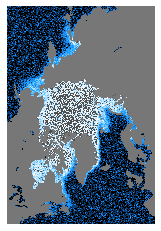

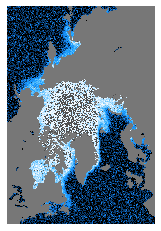

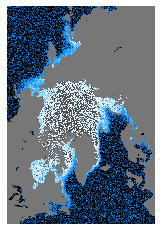

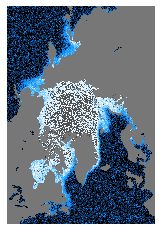

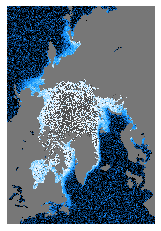

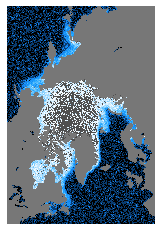

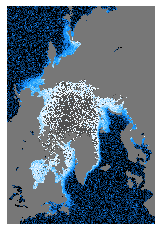

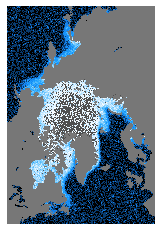

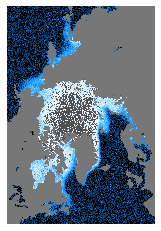

In [188]:
for i in range(10):
    frame = predictions_images[0, i+10, :, :]
    conc_processor.make_colored_prediction_image(frame, image_type='concentration')